# Defining the Rates of Supernova Depending on the Environment

This code reads in a "master table' of data from the Open Supernova Catalog [sne.space](https://sne.space/). We make cuts on ra, dec, and redshift to send to classifyenvironments.py from VoidFinder. From there, host galaxy ra and dec are used to make further cuts to be sent to the SDSS Host Survey. The remaining SNe receive their host's Petrosian r-band apparent magnitude that is converted to absolute magnitude. We make the final cut, keeping SNe that are either classified as void or wall and have an absolute magnitude. Rates are determined by comparing number of SNe to number of galaxies in the DR7 footprint.

In [226]:
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn
from astropy.table import QTable
import astropy.units as u
from astropy.constants import c as c

import json

import os
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import stats

### "Master table" is read in. 

Note that this is not all of the SNe in the catalog. We made a cut in Bluehive on 'claimedtype' that were 'Ia', 'Comet', 'LGRB', and 'removed'.

In [2]:
master_table = Table.read('C:/Users/kaeka/Documents/Python/catalog_table_cut1.txt', format = 'ascii.commented_header')

In [3]:
master_table = master_table['ID', 'claimedtype', 'ra', 'dec', 'redshift', 'redshift_kind', 'host', 'hostra', 'hostdec']

In [46]:
# Table length = 48010
# master_table

In [5]:
master_table['claimedtype'].fill_value = '-999'
master_table['redshift_kind'].fill_value = '-999'
master_table['host'].fill_value = '-999'
master_table['ra'].fill_value = -999.
master_table['dec'].fill_value = -999.
master_table['redshift'].fill_value = -999.
master_table['hostra'].fill_value = -999.
master_table['hostdec'].fill_value = -999.

In [6]:
master_table = master_table.filled()

## ClassifyEnvironments.py cuts
(1) Any SNe that does not have a 'claimedtype'
(2) Any SNe that does not have 'ra' or 'dec'
(3) Any SNe that does not have a 'redshift'
(4) Any SNe that has a redshift of 0.

In [7]:
vflag_cut1 = master_table['claimedtype'] != '-999'
master_table_cut = master_table[vflag_cut1]

vflag_cut2 = master_table_cut['ra'] != -999.
master_table_cut = master_table_cut[vflag_cut2]

vflag_cut3 = master_table_cut['redshift'] != -999.
master_table_cut = master_table_cut[vflag_cut3]

vflag_cut4 = master_table_cut['redshift'] != 0.
master_table_cut = master_table_cut[vflag_cut4]

In [47]:
# Table length = 8515
# master_table_cut

In [9]:
input_vflagTable = master_table_cut['ID', 'ra', 'dec', 'redshift']

In [10]:
# input_vflagTable.write('input_vflagTable.txt', format= 'ascii.commented_header', overwrite=True)

### Read in v_flag table from ClassifyEnvironments.py

In [11]:
vflag_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/input_vflagTable_vflag.txt', format= 'ascii.commented_header')

In [48]:
# Table length = 8515
# vflag_table

In [13]:
# Append vflag to "Master Table"

master_table_cut['vflag'] = -999

for i in range(len(vflag_table)):
    SN_ID = vflag_table['ID'][i]
    idx_bool = master_table_cut['ID'] == SN_ID
    master_table_cut['vflag'][idx_bool] = vflag_table['vflag'][i]

In [50]:
# Table length = 8515
# master_table_cut

## SDSS Host Survey cut

(1) Any SNe that does not have 'hostra' and 'hostdec'.

In [15]:
SQL_cut1 = master_table_cut['hostra'] != -999.
master_table_cut = master_table_cut[SQL_cut1]

In [51]:
# Table length = 4757
# master_table_cut

In [17]:
input_sqlTable = master_table_cut['ID', 'hostra', 'hostdec']

In [18]:
# input_sqlTable.write('input_sqlTable.txt', format='ascii.commented_header', overwrite=True)

### Read in r_mag table from SDSS search

In [19]:
rmag_table = Table.read('C:/Users/kaeka/Documents/Python/jupyter_notebook/SQL_Table_rmag.csv', format= 'ascii.csv')

In [52]:
# Table length = 3465
# rmag_table

In [21]:
master_table_cut['rmag'] = -999.

for i in range(len(rmag_table)):
    gal_ID = rmag_table['ID'][i]
    idx_bool = master_table_cut['ID'] == gal_ID
    master_table_cut['rmag'][idx_bool] = rmag_table['petroMag_r'][i]

In [22]:
# Append vflag and rmag to "Master Table"

master_table['vflag'] = -999
master_table['rmag'] = -999.

for i in range(len(master_table_cut)):
    SN_ID = master_table_cut['ID'][i]
    idx_bool = master_table['ID'] == SN_ID
    master_table['vflag'][idx_bool] = master_table_cut['vflag'][i]

for i in range(len(master_table_cut)):
    gal_ID = master_table_cut['ID'][i]
    idx_bool = master_table['ID'] == gal_ID
    master_table['rmag'][idx_bool] = master_table_cut['rmag'][i]

In [23]:
# master_table

## Function for Absolute Magnitude calculation.
### Note: This still needs to be K-corrected.

In [24]:
# Calculating absolute magnitude.
def abs_mag(m, z, K=0, h=1.):
    """Convert apparent magnitude to absolute magnitude using the distance modulus
    
    M - m = 5 log10(d / 10 pc), where d = cz/H0 (assuming z < 0.1)
    
    Parameters
    ----------
    m : float
        Apparent magnitude; assume r-band.
    z : float
        Redshift.
    K : float
        K-correction.
    h : float
        Dimensionless scaling parameter for Hubble's constant H0.
        
    Returns
    -------
    M : float
        Absolute magnitude (assume r-band).
    """
    H0 = 100 * u.km/u.s/u.Mpc * h
    d = ((c * z) / H0)
    M = m - 5*np.log10(d / (10*u.pc)) - K
    
    return M

In [25]:
master_table['abs_mag'] = abs_mag(master_table['rmag'], master_table['redshift'])

for i in range(len(master_table)):
    no_rmag = master_table['rmag'] == -999.
    master_table['abs_mag'][no_rmag] = -999.

C:\Users\kaeka\Anaconda3\lib\site-packages\astropy\units\quantity.py:461: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\kaeka\Anaconda3\lib\site-packages\astropy\units\quantity.py:461: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Check to see if SDSS Host Search missed any hosts.
This is checking all void or wall SNe that have host ra and dec and don't have an rmag.

In [26]:
r_cut2 = master_table['vflag'] != 9
rmag_master_table = master_table[r_cut2]

r_cut3 = rmag_master_table['vflag'] != 2
rmag_master_table = rmag_master_table[r_cut3]

r_cut4 = rmag_master_table['vflag'] != -999
rmag_master_table = rmag_master_table[r_cut4]

In [27]:
check_SDSS = rmag_master_table[rmag_master_table['rmag'] == -999.]

16 entries that have been manually looked up in SDSS DR15 database.

In [53]:
# check_SDSS.show_in_notebook()

In [29]:
check_SDSS[0]['rmag'] = 10.62796
check_SDSS[3]['rmag'] = 14.67315
check_SDSS[5]['rmag'] = 11.77488
check_SDSS[6]['rmag'] = 14.67315
check_SDSS[7]['rmag'] = 10.40886
check_SDSS[8]['rmag'] = 11.77488
check_SDSS[10]['rmag'] = 14.67315
check_SDSS[13]['rmag'] = 14.67315
check_SDSS[14]['rmag'] = 20.14939

In [54]:
# Table length = 16
# check_SDSS

In [31]:
# Append check_SDSS to master_table

for i in range(len(check_SDSS)):
    SN_ID = check_SDSS['ID'][i]
    idx_bool = master_table['ID'] == SN_ID
    master_table['rmag'][idx_bool] = check_SDSS['rmag'][i]

In [32]:
# Run abs_mag function again to fill the 16 SNe missed.
master_table['abs_mag'] = abs_mag(master_table['rmag'], master_table['redshift'])

In [34]:
# master_table.write('COMPLETE_catalog_table_cut1.txt', format='ascii.commented_header', overwrite=True)

## Cuts to master table
(1) cut1 = any host galaxy without rmag value, meaning no host ra or host dec, (2) cut2 = any SN outside of DR7 footprint, (3) cut3 = any SN on edge of DR7 footprint, (4) cut4 = all SN that did not have an ra, dec, and redshift to put into classifyenvironments.py

In [35]:
f_cut1 = master_table['rmag'] != -999.
fcut_master_table = master_table[f_cut1]

f_cut2 = fcut_master_table['vflag'] != 9
fcut_master_table = fcut_master_table[f_cut2]

f_cut3 = fcut_master_table['vflag'] != 2
fcut_master_table = fcut_master_table[f_cut3]

f_cut4 = fcut_master_table['vflag'] != -999
fcut_master_table = fcut_master_table[f_cut4]

In [55]:
# Table length = 672
# fcut_master_table

### looking at 'claimedtype,' there are Ia types listed. This is the first check for Ia to remove it.

In [37]:
Ia_rows, keep_rows, del_rows = [], [], []
for i in range(len(fcut_master_table)):
    Ia_check = fcut_master_table['claimedtype'][i]
    if 'Ia' in Ia_check:
        Ia_rows.append(i)
        split = Ia_check.split(', ')
        for j in range(len(split)):
            if 'Ia' not in split[j]:
                keep_rows.append(i)

for i in range(len(keep_rows)):
    keep_num = keep_rows[i]
    if keep_num in Ia_rows:
        Ia_rows.remove(keep_num)
                
                
            
fcut_master_table.remove_rows(Ia_rows)

In [56]:
# Table length = 575
# fcut_master_table

In [39]:
# fcut_master_table.show_in_notebook()

### Second check for Ia

In [58]:
for i in range(len(fcut_master_table)):
    Ia_check2 = fcut_master_table['claimedtype'][i]
    if 'Ia' in Ia_check2:
        print(i, Ia_check2)

139 Ia, Ic, Ib/c
148 Ic, Ia
159 Ia-02cx, Ia, II
169 II, Ia
215 Ic, Ia
228 Ic, Ia
392 II, Ia, IIb
405 Ia, Ic
448 Ia, II
477 Ia, IIb


In [41]:
fcut_master_table.remove_rows([81, 83, 94, 99, 106, 114, 119, 131, 192])

### Last check for Ia

In [59]:
for i in range(len(fcut_master_table)):
    Ia_check3 = fcut_master_table['claimedtype'][i]
    if 'Ia' in Ia_check3:
        print(i, Ia_check3)

139 Ia, Ic, Ib/c
148 Ic, Ia
159 Ia-02cx, Ia, II
169 II, Ia
215 Ic, Ia
228 Ic, Ia
392 II, Ia, IIb
405 Ia, Ic
448 Ia, II
477 Ia, IIb


In [61]:
# Table length = 566
fcut_master_table

ID,claimedtype,ra,dec,redshift,redshift_kind,host,hostra,hostdec,vflag,rmag,abs_mag
,,,,,,,,,,,
int32,str49,float64,float64,float64,str27,str99,float64,float64,int32,float64,float64
37,II,193.24249999999998,32.41925,0.022805,-999,SDSS J125258.03+322444.3,193.24179166666664,32.412305555555555,0,16.00054,-18.173713897524422
50,II,169.67095833333332,25.166633333333333,0.0254,-999,SDSS J111840.97+250958.5,169.67070833333332,25.166249999999998,0,17.81347,-16.59480209773933
111,"Ib, Ibn",196.0362083333333,52.312916666666666,0.065,-999,SDSS J130408.52+521846.4,196.03549999999998,52.312888888888885,1,20.80107,-15.647600297853916
174,IIn,165.51979166666663,3.500738888888889,0.0348,-999,SDSS J110204.81+033003.1,165.52004166666666,3.500861111111111,0,17.99434,-17.09765973437254
210,Ib,210.5651666666666,33.66119166666667,0.034371,-999,"PGC 2036567, 2MASX J14021617+3339415, 2MASX J14021617+3339",210.56737499999997,33.66152777777778,0,15.92106,-19.14400435370285
212,II,231.34791666666663,29.173472222222223,0.021466,-999,SDSS J152523.40+291018.8,231.34749999999997,29.17188888888889,1,15.69168,-18.35117913976186
220,Ic,234.60541666666663,46.90183333333333,0.043,-999,SDSS J153825.20+465404.1,234.60499999999996,46.90113888888889,1,18.36746,-17.18398579253757
250,IIn,152.0343333333333,19.29982777777778,0.033574,-999,SDSS J100807.76+191758.2,152.0323333333333,19.299500000000002,1,16.64836,-18.365758945103703


In [69]:
# fcut_master_table.write('FINALcut_SNtable.txt', format='ascii.commented_header', overwrite=True)

In [45]:
wall_sn = float(np.sum(fcut_master_table['vflag'] == 0))
void_sn = float(np.sum(fcut_master_table['vflag'] == 1))

print('Wall: ', wall_sn)
print('Void: ', void_sn)

Wall:  249.0
Void:  317.0


## Separating by void/wall and by abs. magnitude
A new table is created, boolean values are made to separte void and wall SNe. A function is used to separate by absolute magnitude.

In [70]:
# -- importing data into an astropy table
sn_table = Table.read('FINALcut_SNtable.txt', format='ascii.commented_header', include_names=['vflag', 'abs_mag'])

In [72]:
### Separating void/wall and magnitude.
vbool = sn_table['vflag'] == 1
wbool = sn_table['vflag'] == 0

v_sn = sn_table[vbool]
w_sn = sn_table[wbool]

# -- magnitude scale is backwards, these are correct
def mag_split(data_table):
   dwbool    = data_table['abs_mag']>-17
   brbool    = data_table['abs_mag']<-20
   bool17_18 = np.logical_and(data_table['abs_mag']<-17,data_table['abs_mag']>-18)
   bool18_19 = np.logical_and(data_table['abs_mag']<-18,data_table['abs_mag']>-19)
   bool19_20 = np.logical_and(data_table['abs_mag']<-19,data_table['abs_mag']>-20)

   dwarf_table  = data_table[dwbool]
   bright_table = data_table[brbool]
   table17_18   = data_table[bool17_18]
   table18_19   = data_table[bool18_19]
   table19_20   = data_table[bool19_20]

   return dwarf_table, bright_table, table17_18, table18_19, table19_20

In [97]:
vdwarf_table, vbright_table, v17_18table, v18_19table, v19_20table = mag_split(v_sn)

wdwarf_table, wbright_table, wtable17_18, wtable18_19, wtable19_20 = mag_split(w_sn)

# mag_split(sn_table)

# Histograms

In [246]:
### Making a histogram.
def make_hist(void_input, wall_input, _bins):
    fig, ax = plt.subplots(1, 1)
    
    return (ax.hist(void_input, bins = _bins, color='red', alpha=0.5, density=1, label='void SN'),
            ax.hist(wall_input, bins = _bins, color='black', alpha=0.5, density=1, label='wall SN'),
            ax.legend(), 
            ax.set(xlabel = 'Absolute magnitude, $M_r$'),
            ax.grid(alpha=0.5))

Text(0.5, 0, 'Absolute Magnitude, $M_r$')

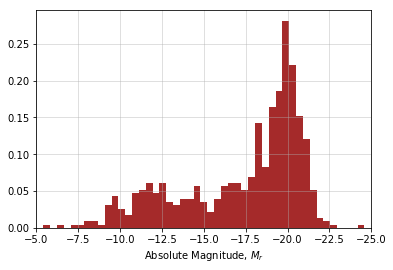

In [247]:
### Plot of 566 SN by all M_r. (normalized)

plt.hist(fcut_master_table['abs_mag'], bins = np.linspace(-25, -5, 50), color='brown', density=1)
plt.xlim(-5,-25)
plt.grid(alpha=0.5)
plt.xlabel('Absolute Magnitude, $M_r$')

Void/Wall of all M_r


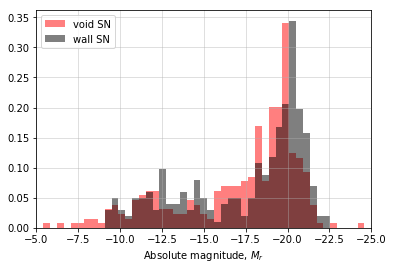

In [300]:
### Histogram of SN separated into void and wall of all M_r.
make_hist(v_sn['abs_mag'], w_sn['abs_mag'], np.linspace(-25, -5, 50))
plt.xlim(-5,-25)
print('Void/Wall of all M_r')

Dwarf


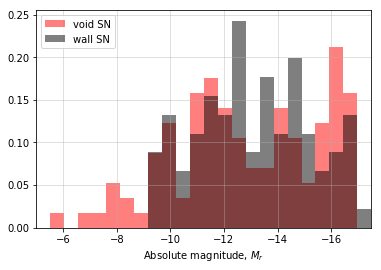

In [298]:
### DWARF ( > -17)
make_hist(vdwarf_table['abs_mag'], wdwarf_table['abs_mag'], np.linspace(-17.5, -5, 25))
plt.xlim(-5,-17.5)
print('Dwarf')

17-18


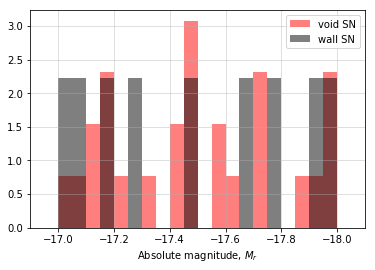

In [297]:
### 17-18
make_hist(v17_18table['abs_mag'], wtable17_18['abs_mag'], np.linspace(-18.1, -16.9, 25))
plt.xlim(-16.9,-18.1)
print('17-18')

18-19


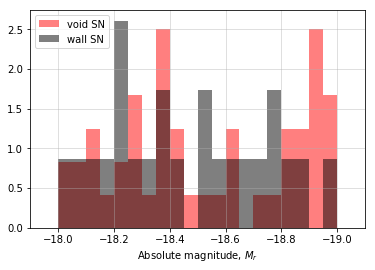

In [251]:
### 18-19
make_hist(v18_19table['abs_mag'], wtable18_19['abs_mag'], np.linspace(-19.1, -17.9, 25))
plt.xlim(-17.9,-19.1)
print('18-19')

19-20


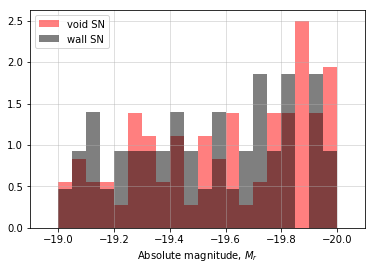

In [252]:
### 19-20
make_hist(v19_20table['abs_mag'], wtable19_20['abs_mag'], np.linspace(-20.1, -18.9, 25))
plt.xlim(-18.9,-20.1)
print('19-20')

Bright


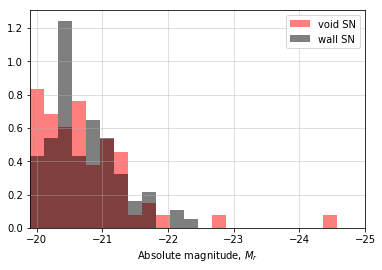

In [253]:
### BRIGHT (< -20)
make_hist(vbright_table['abs_mag'], wbright_table['abs_mag'], np.linspace(-25, -19.9, 25))
plt.xlim(-19.9,-25)
print('Bright')

### KS Test
Comparing

## Diagnostic Plots

Mollweide projection of SN ra and dec. Redshift histogram. (RA hist and dec hist for hosts?)

Text(0, 0.5, 'Dec')

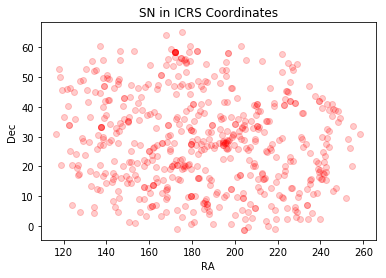

In [301]:
plt.plot(fcut_master_table['ra'], fcut_master_table['dec'], 'ro', alpha = 0.2)
plt.title('SN in ICRS Coordinates')
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0.5, 0, 'Redshift, z')

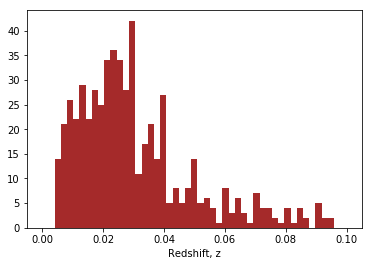

In [272]:
plt.hist(fcut_master_table['redshift'], bins=np.linspace(0.0, 0.1, 50), color='brown')
plt.xlabel('Redshift, z')

### Number of SN in each category:

In [283]:
void_sn = float(np.sum(v_sn['vflag'] == 1))
wall_sn = float(np.sum(w_sn['vflag'] == 0))

vDwarf_sn = float(np.sum(vdwarf_table['vflag'] == 1))
wDwarf_sn = float(np.sum(wdwarf_table['vflag'] == 0))

v1718_sn = float(np.sum(v17_18table['vflag'] == 1))
w1718_sn = float(np.sum(wtable17_18['vflag'] == 0))

v1819_sn = float(np.sum(v18_19table['vflag'] == 1))
w1819_sn = float(np.sum(wtable18_19['vflag'] == 0))

v1920_sn = float(np.sum(v19_20table['vflag'] == 1))
w1920_sn = float(np.sum(wtable19_20['vflag'] == 0))

vBright_sn = float(np.sum(vbright_table['vflag'] == 1))
wBright_sn = float(np.sum(wbright_table['vflag'] == 0))

print(void_sn, wall_sn, vDwarf_sn, wDwarf_sn, v1718_sn, w1718_sn, v1819_sn, w1819_sn, v1920_sn, w1920_sn, 
      vBright_sn, wBright_sn)

317.0 249.0 109.0 87.0 26.0 9.0 48.0 23.0 72.0 43.0 62.0 87.0


### Number of Galaxies in each catagory:

In [286]:
void_gal = 75254.
wall_gal = 620555.

vDwarf_gal = 2942.
wDwarf_gal = 3681.

v1718_gal = 3894.
w1718_gal = 9769.

v1819_gal = 8932.
w1819_gal = 21161.

v1920_gal = 8167.
w1920_gal = 20279.

vBright_gal = 51319.
wBright_gal = 565665.

print(void_gal, wall_gal, vDwarf_gal, wDwarf_gal, v1718_gal, w1718_gal, v1819_gal, w1819_gal, v1920_gal, w1920_gal, 
      vBright_gal, wBright_gal)

75254.0 620555.0 2942.0 3681.0 3894.0 9769.0 8932.0 21161.0 8167.0 20279.0 51319.0 565665.0


## Rates of finding SNe in a specific environment, depending on absolute magnitude.

In [292]:
void_rate = void_sn/void_gal
wall_rate =  wall_sn/wall_gal

vDwarf_rate = vDwarf_sn/vDwarf_gal
wDwarf_rate = wDwarf_sn/wDwarf_gal

v1718_rate = v1718_sn/v1718_gal
w1718_rate = w1718_sn/w1718_gal

v1819_rate = v1819_sn/v1819_gal
w1819_rate = w1819_sn/w1819_gal

v1920_rate = v1920_sn/v1920_gal
w1920_rate = w1920_sn/w1920_gal

vBright_rate = vBright_sn/vBright_gal
wBright_rate = wBright_sn/wBright_gal

# Rates:

In [294]:
print('Void SN Rate: ', void_rate)
print('Wall SN Rate: ', wall_rate)
print('-------------------------------------')
print('Dwarf Void SN Rate: ', vDwarf_rate)
print('Dwarf Wall SN Rate: ', wDwarf_rate)
print('-------------------------------------')
print('17-18 Void SN Rate: ', v1718_rate)
print('17-18 Wall SN Rate: ', w1718_rate)
print('-------------------------------------')
print('18-19 Void SN Rate: ', v1819_rate)
print('18-19 Wall SN Rate: ', w1819_rate)
print('-------------------------------------')
print('19-20 Void SN Rate: ', v1920_rate)
print('19-20 Wall SN Rate: ', w1920_rate)
print('-------------------------------------')
print('Bright Void SN Rate: ', vBright_rate)
print('Bright Wall SN Rate: ', wBright_rate)

Void SN Rate:  0.004212400669731842
Wall SN Rate:  0.0004012537164312591
-------------------------------------
Dwarf Void SN Rate:  0.03704962610469069
Dwarf Wall SN Rate:  0.023634881825590873
-------------------------------------
17-18 Void SN Rate:  0.00667693888032871
17-18 Wall SN Rate:  0.0009212816050772853
-------------------------------------
18-19 Void SN Rate:  0.005373936408419167
18-19 Wall SN Rate:  0.0010869051557109777
-------------------------------------
19-20 Void SN Rate:  0.008815966695236929
19-20 Wall SN Rate:  0.0021204201390601115
-------------------------------------
Bright Void SN Rate:  0.0012081295426645102
Bright Wall SN Rate:  0.00015380127814165629
